### Importing relevent libraries

In [28]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [3]:
os.chdir("..")

In [4]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

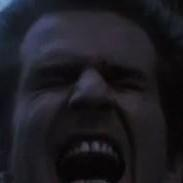

In [5]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [6]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 64
IMG_HEIGHT = 200
IMG_WIDTH = 200

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [7]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [49]:
emotion_mapping = {v: k for v, k in enumerate(class_names)}
emotion_mapping

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

### Creating custom model.

In [13]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.SpatialDropout2D(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug_2 = tf.keras.Model(inputs, outputs)

In [14]:
model_norm_aug_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 average_pooling2d_3 (Averag  (None, 100, 100, 32)     0         
 ePooling2D)                                                     
                                                           

In [15]:
LR = 1e-4
EPOCHS = 15

model_norm_aug_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

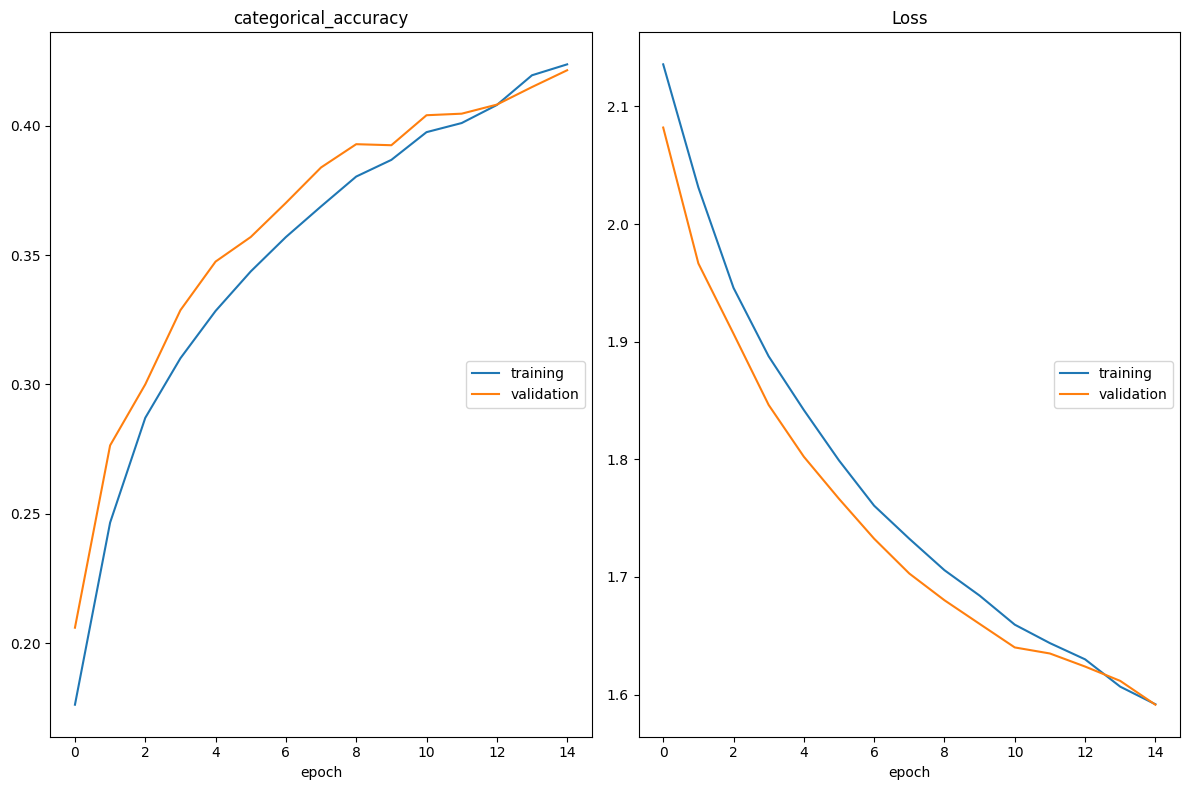

categorical_accuracy
	training         	 (min:    0.176, max:    0.424, cur:    0.424)
	validation       	 (min:    0.206, max:    0.421, cur:    0.421)
Loss
	training         	 (min:    1.592, max:    2.136, cur:    1.592)
	validation       	 (min:    1.591, max:    2.082, cur:    1.591)
626/626 [==============================] - 101s 160ms/step - loss: 1.5917 - categorical_accuracy: 0.4237 - val_loss: 1.5913 - val_categorical_accuracy: 0.4214


In [17]:
history_norm_aug = model_norm_aug_2.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is very good, without overfitting. Saving as best model.</b>

In [23]:
model_norm_aug_2.save('models/model_norm_aug_custom_2/model_norm_aug_custom_2_15', save_format='h5')

In [10]:
model_norm_aug_2 = tf.keras.models.load_model('models/model_norm_aug_custom_2/model_norm_aug_custom_2_15')

### Testing model with test data

In [ ]:
# Creating lists of images and paths
images = []
paths = []
for img in os.listdir(DATA_DIR_TEST):
    img = os.path.join(DATA_DIR_TEST, img)
    paths.append(img)
    img = image.load_img(img, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)

In [23]:
# Stack up images list to pass for prediction
images = np.vstack(images)
# Prediction
pred = model_norm_aug_2.predict(data_test)

In [45]:
# Indexes of predicted emotions
emotion_index = np.argmax(pred, axis=1)
# List of emotions
emotion = [emotion_mapping[i] for i in emotion_index]
# List with image numbers as Ints
image_number = [int(i.split('\\')[-1].split('.')[0]) for i in paths]

In [63]:
# Creating dataframe with image numbers and emotions
df_predictions = pd.DataFrame({'image_path': image_number,
                               'emotion': emotion})
# Sorting by number column
df_predictions = df_predictions.sort_values(by='image_path', ignore_index=True)
# Converting number column to str and formatting as in sample_submission
df_predictions['image_path'] = df_predictions['image_path'].map(lambda x: str(x) + '.jpg')
# Creating csv file
df_predictions.to_csv('submission.csv', index=False)